In [1]:
# Imports
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F  # Make sure this import is here
import random
import math

In [3]:
# COCO Dataset for lat and lon only
class COCOGeolocationDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.geolocations, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        input_size = num_classes * max_instances_per_class * 4  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        geolocations = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            
            # Extract the expensive GPS data as the target output
            expensive_latitude = float(image_info['expensive_latitude'])
            expensive_longitude = float(image_info['expensive_longitude'])
            # Ensure that only latitude and longitude are included
            geolocation = [expensive_latitude, expensive_longitude]
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            geolocations.append(geolocation)  # Only latitude and longitude are appended
            image_files.append(image_info['file_name'])

        return bounding_boxes, geolocations, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        geolocation = torch.tensor(self.geolocations[idx], dtype=torch.float32)  # This should now be of shape [2]
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, geolocation, image_path

In [4]:
class COCOCompassDataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.orientations, self.lat_lons, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9  # Adjusted based on the dataset
        input_size = num_classes * max_instances_per_class * 4  # 9 classes * 2 instances per class * 4 points per bbox
        bounding_boxes = []
        orientations = []
        lat_lons = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']
            
            # Extract the compass orientation as the target output
            compass_orientation = float(image_info['expensive_heading'])
            
            # Initialize the input vector with zeros
            input_vector = [0] * input_size

            # Find annotations corresponding to the image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    input_vector[start_index:start_index + 4] = bbox

            # Append the latitude and longitude
            lat = float(image_info.get('latitude', 0))  # Default to 0 if not found
            lon = float(image_info.get('longitude', 0))  # Default to 0 if not found

            bounding_boxes.append(input_vector)
            orientations.append(compass_orientation)  # Only compass orientation is appended
            lat_lons.append([lat, lon])  # Add lat and lon as part of the input
            image_files.append(image_info['file_name'])

        return bounding_boxes, orientations, lat_lons, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        lat_lon = torch.tensor(self.lat_lons[idx], dtype=torch.float32)
        orientation = torch.tensor([self.orientations[idx]], dtype=torch.float32)  # This should now be a single value in a tensor
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        
        # Combine bounding box and lat/lon into a single input tensor
        combined_input = torch.cat((bounding_box, lat_lon), dim=0)
        
        return combined_input, orientation, image_path

In [10]:
# FFNN Arch.
class LatLonModel(nn.Module):
    def __init__(self):
        super(LatLonModel, self).__init__()
        self.fc1 = nn.Linear(72, 40)  # Single hidden layer with 40 neurons
        self.bn1 = nn.BatchNorm1d(40)  # Batch normalization
        self.fc2 = nn.Linear(40, 2)    # Output layer (latitude and longitude)
        self.dropout = nn.Dropout(p=0.3)  # DropoutRuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))  # Hidden layer with batch normalization and activation
        x = self.dropout(x)  # Apply dropout before the final output layer
        x = self.fc2(x)  # Output layer
        return x

# class CompassModel(nn.Module):
#     def __init__(self):
#         super(CompassModel, self).__init__()
        
#         # First fully connected layer
#         self.fc1 = nn.Linear(74, 128)  # Input size should be 74 to match your data
#         self.bn1 = nn.BatchNorm1d(128)
#         self.dropout1 = nn.Dropout(p=0.3)
        
#         # Second fully connected layer
#         self.fc2 = nn.Linear(128, 72)
#         self.bn2 = nn.BatchNorm1d(72)
#         self.dropout2 = nn.Dropout(p=0.3)
        
#         # Third fully connected layer
#         self.fc3 = nn.Linear(72, 64)
#         self.bn3 = nn.BatchNorm1d(64)
#         self.dropout3 = nn.Dropout(p=0.3)
        
#         # Output layer
#         self.fc4 = nn.Linear(64, 1)

#     def forward(self, x):
#         # First hidden layer with batch normalization, activation, and dropout
#         x = F.leaky_relu(self.bn1(self.fc1(x)))
#         x = self.dropout1(x)
        
#         # Second hidden layer with batch normalization, activation, and dropout
#         x = F.leaky_relu(self.bn2(self.fc2(x)))
#         x = self.dropout2(x)
        
#         # Third hidden layer with batch normalization, activation, and dropout
#         x = F.leaky_relu(self.bn3(self.fc3(x)))
#         x = self.dropout3(x)
        
#         # Output layer
#         x = self.fc4(x)
#         return x
        
# class CompassModel(nn.Module):     ###
#     def __init__(self):
#         super(CompassModel, self).__init__()
        
#         # Bidirectional LSTM layer with dropout
#         self.lstm = nn.LSTM(input_size=74, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(128 * 2, 128)  # 128 * 2 because of bidirectional LSTM
#         self.fc2 = nn.Linear(128, 64)
#         self.bn1 = nn.BatchNorm1d(64)
#         self.dropout1 = nn.Dropout(p=0.3)
        
#         # Output layer
#         self.fc3 = nn.Linear(64, 1)

#     def forward(self, x):
#         # Add a dimension for sequence length
#         x = x.unsqueeze(1)
        
#         # LSTM layer
#         lstm_out, _ = self.lstm(x)
#         x = lstm_out[:, -1, :]  # Take the output of the last time step from the LSTM
        
#         # First fully connected layer
#         residual = x  # Save the residual (256-dimensional)
#         x = F.leaky_relu(self.fc1(x))  # Output of fc1 is 128-dimensional
        
#         # Second fully connected layer with batch normalization and dropout
#         x = F.leaky_relu(self.bn1(self.fc2(x)))
#         x = self.dropout1(x)
        
#         # Output layer
#         x = self.fc3(x)
#         return x

class ImprovedCompassModel(nn.Module):
    def __init__(self):
        super(ImprovedCompassModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size=74, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        
        
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

# class CompassModel(nn.Module):
#     def __init__(self):
#         super(CompassModel, self).__init__()
        
#         # LSTM layer
#         self.lstm = nn.LSTM(input_size=74, hidden_size=128, num_layers=1, batch_first=True)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(128, 64)
#         self.fc2 = nn.Linear(64, 48)
#         self.fc3 = nn.Linear(48, 32)
#         self.bn1 = nn.BatchNorm1d(32)
#         self.dropout1 = nn.Dropout(p=0.3)
        
#         # Output layer
#         self.fc4 = nn.Linear(32, 1)

#     def forward(self, x):
#         # Add a dimension for sequence length
#         x = x.unsqueeze(1)
        
#         # LSTM layer
#         x, _ = self.lstm(x)
#         x = x[:, -1, :]  # Take the output of the last time step
        
#         # First fully connected layer with activation
#         x = F.leaky_relu(self.fc1(x))
        
#         # Second fully connected layer with activation
#         x = F.leaky_relu(self.fc2(x))
        
#         # Third fully connected layer with batch normalization and dropout
#         x = F.leaky_relu(self.bn1(self.fc3(x)))
#         x = self.dropout1(x)
        
#         # Output layer
#         x = self.fc4(x)
#         return x

# class ImprovedCompassModel(nn.Module):
#     def __init__(self):
#         super(ImprovedCompassModel, self).__init__()
        
#         # Fully connected layers with increased capacity
#         self.fc1 = nn.Linear(74, 128)  # Input size is 74 since we're no longer using LSTM
#         self.fc2 = nn.Linear(128, 128)
#         self.bn1 = nn.BatchNorm1d(128)
#         self.dropout1 = nn.Dropout(p=0.2)
        
#         # Additional fully connected layer
#         self.fc3 = nn.Linear(128, 64)
#         self.bn2 = nn.BatchNorm1d(64)
#         self.dropout2 = nn.Dropout(p=0.2)
        
#         # Final fully connected layer before output
#         self.fc4 = nn.Linear(64, 32)
#         self.bn3 = nn.BatchNorm1d(32)
#         self.dropout3 = nn.Dropout(p=0.2)
        
#         # Output layer
#         self.fc5 = nn.Linear(32, 1)

#     def forward(self, x):
#         # First fully connected layer with activation
#         x = F.leaky_relu(self.fc1(x))
        
#         # Second fully connected layer with batch normalization and dropout
#         x = F.leaky_relu(self.bn1(self.fc2(x)))
#         x = self.dropout1(x)
        
#         # Third fully connected layer with batch normalization and dropout
#         x = F.leaky_relu(self.bn2(self.fc3(x)))
#         x = self.dropout2(x)
        
#         # Fourth fully connected layer with batch normalization and dropout
#         x = F.leaky_relu(self.bn3(self.fc4(x)))
#         x = self.dropout3(x)
        
#         # Output layer
#         x = self.fc5(x)
#         return x

# class ImprovedCompassModel(nn.Module):
#     def __init__(self):
#         super(ImprovedCompassModel, self).__init__()
        
#         # First fully connected layer
#         self.fc1 = nn.Linear(74, 128)
#         self.bn1 = nn.BatchNorm1d(128)
#         self.dropout1 = nn.Dropout(p=0.2)
        
#         # Second fully connected layer
#         self.fc2 = nn.Linear(128, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.dropout2 = nn.Dropout(p=0.2)
        
#         # Third fully connected layer
#         self.fc3 = nn.Linear(128, 128)  # Keep this layer size same as previous layer for residual connection
#         self.bn3 = nn.BatchNorm1d(128)
#         self.dropout3 = nn.Dropout(p=0.2)
        
#         # Fourth fully connected layer
#         self.fc4 = nn.Linear(128, 64)  # Reduced size for output compatibility
#         self.bn4 = nn.BatchNorm1d(64)
#         self.dropout4 = nn.Dropout(p=0.2)
        
#         # Output layer
#         self.fc5 = nn.Linear(64, 1)

#     def forward(self, x):
#         # First fully connected layer
#         x = F.leaky_relu(self.bn1(self.fc1(x)))
#         x = self.dropout1(x)
        
#         # Second fully connected layer with residual connection
#         residual = x
#         x = F.leaky_relu(self.bn2(self.fc2(x)))
#         x = self.dropout2(x)
#         x = x + residual  # Residual connection
        
#         # Third fully connected layer with residual connection
#         residual = x
#         x = F.leaky_relu(self.bn3(self.fc3(x)))
#         x = self.dropout3(x)
#         x = x + residual  # Residual connection
        
#         # Fourth fully connected layer
#         x = F.leaky_relu(self.bn4(self.fc4(x)))
#         x = self.dropout4(x)
        
#         # Output layer
#         x = self.fc5(x)
#         return x

class CombinedModel(nn.Module):
    def __init__(self, lat_lon_model, compass_model):
        super(CombinedModel, self).__init__()
        self.lat_lon_model = lat_lon_model  # Pre-trained LatLonModel
        self.compass_model = compass_model  # Pre-trained CompassModel

    def forward(self, x):
        lat_lon_output = self.lat_lon_model(x)  # Predict lat and lon
        compass_output = self.compass_model(x)  # Predict compass orientation
        combined_output = torch.cat((lat_lon_output, compass_output), dim=1)  # Combine outputs
        return combined_output  # Output: [latitude, longitude, compass orientation]


In [6]:
# Load the COCO JSON data
coco_file_path = 'Test_4/Filtered_Lat_Lon_2BBox_Each_Class_Annotation.json'  
images_dir = 'Test_4/captured_images_test4' 

# Create the dataset for latitude and longitude
lat_lon_dataset = COCOGeolocationDataset(coco_file_path, images_dir)

print(f"Example bounding box for Lat/Lon: {lat_lon_dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(lat_lon_dataset))
test_size = len(lat_lon_dataset) - train_size
lat_lon_train_dataset, lat_lon_test_dataset = random_split(lat_lon_dataset, [train_size, test_size])

# Create dataloaders
lat_lon_train_dataloader = DataLoader(lat_lon_train_dataset, batch_size=32, shuffle=True)
lat_lon_test_dataloader = DataLoader(lat_lon_test_dataset, batch_size=32, shuffle=False)

# Create the dataset for compass orientation
compass_dataset = COCOCompassDataset(coco_file_path, images_dir)

print(f"Example bounding box for Compass: {compass_dataset[0][0].shape}")

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(compass_dataset))
test_size = len(compass_dataset) - train_size
compass_train_dataset, compass_test_dataset = random_split(compass_dataset, [train_size, test_size])

# Create dataloaders
compass_train_dataloader = DataLoader(compass_train_dataset, batch_size=10, shuffle=True)
compass_test_dataloader = DataLoader(compass_test_dataset, batch_size=10, shuffle=False)
# Load a single batch from the compass_train_dataloader
for inputs, targets, paths in compass_train_dataloader:
    # Assuming targets contain the compass orientation
    compass_orientation = targets[0].item()  # Get the first compass orientation in the batch
    print(f"Compass Orientation: {compass_orientation}")
    break  # Exit after the first batch

Example bounding box for Lat/Lon: torch.Size([72])
Example bounding box for Compass: torch.Size([74])
Compass Orientation: 87.13949584960938


In [13]:
# Initialize CompassModel
compass_model = ImprovedCompassModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(compass_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Training loop for CompassModel
num_epochs = 300

for epoch in range(num_epochs):
    compass_model.train()
    running_loss = 0.0
    for inputs, targets, _ in compass_train_dataloader:
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass through the compass_model
        outputs = compass_model(inputs)
        
        # Ensure shapes match
        assert outputs.shape == targets.shape, "Shape mismatch between outputs and targets!"

        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    
    # Step the scheduler after each epoch
    scheduler.step()

    # Calculate the average loss over the epoch
    epoch_loss = running_loss / len(compass_train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Compass Loss: {epoch_loss:.8f}')
    
# Save the trained CompassModel
compass_model_save_path = "compass_model_combined.pt"
torch.save(compass_model.state_dict(), compass_model_save_path)
print("Compass model training completed!")

Epoch [1/300], Compass Loss: 33495.14622456
Epoch [2/300], Compass Loss: 31402.53052878
Epoch [3/300], Compass Loss: 27304.86251747
Epoch [4/300], Compass Loss: 22553.10530636
Epoch [5/300], Compass Loss: 18670.08180615
Epoch [6/300], Compass Loss: 15434.41629168
Epoch [7/300], Compass Loss: 13251.14573823
Epoch [8/300], Compass Loss: 11117.23942972
Epoch [9/300], Compass Loss: 8708.47716529
Epoch [10/300], Compass Loss: 7628.30292532
Epoch [11/300], Compass Loss: 6603.38994689
Epoch [12/300], Compass Loss: 6162.78714213
Epoch [13/300], Compass Loss: 6290.31153912
Epoch [14/300], Compass Loss: 5971.70733363
Epoch [15/300], Compass Loss: 5819.92686448
Epoch [16/300], Compass Loss: 5637.25584342
Epoch [17/300], Compass Loss: 5773.47259018
Epoch [18/300], Compass Loss: 5528.07248345
Epoch [19/300], Compass Loss: 5576.22268733
Epoch [20/300], Compass Loss: 5173.32901533
Epoch [21/300], Compass Loss: 5404.48637376
Epoch [22/300], Compass Loss: 5294.19650717
Epoch [23/300], Compass Loss: 521

Mean Squared Error on Compass Test Set: 7563.91259766
Root Mean Squared Error (RMSE) on Compass Test Set: 86.97075714
Actual Compass: 214.25065613
Predicted Compass: 207.80685425


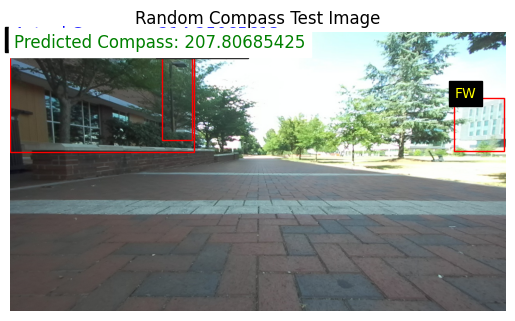

Actual Compass: 357.14135742
Predicted Compass: 272.50289917


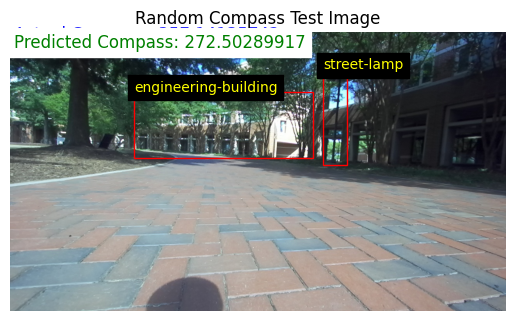

Actual Compass: 212.08218384
Predicted Compass: 121.05663300


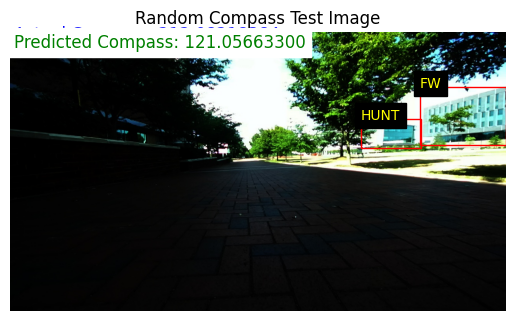

Actual Compass: 36.92508316
Predicted Compass: 43.13917160


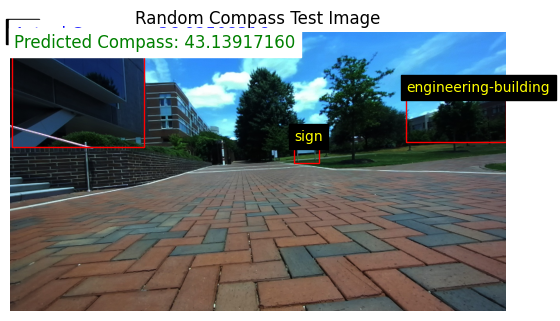

Actual Compass: 22.49368858
Predicted Compass: 27.25778580


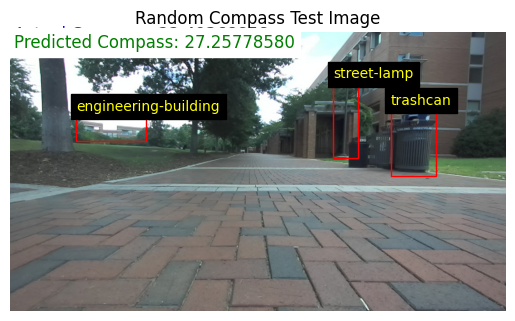

Actual Compass: 17.78672218
Predicted Compass: 65.23409271


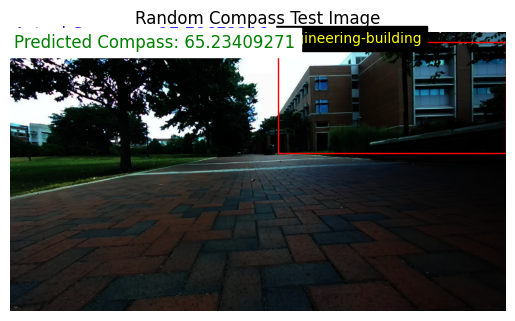

Actual Compass: 29.15532875
Predicted Compass: 36.73965454


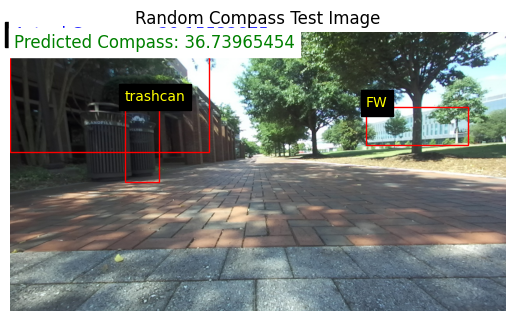

Actual Compass: 300.23956299
Predicted Compass: 63.69448853


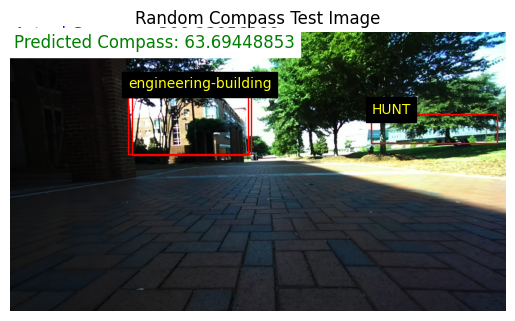

Actual Compass: 36.56363678
Predicted Compass: 61.15530014


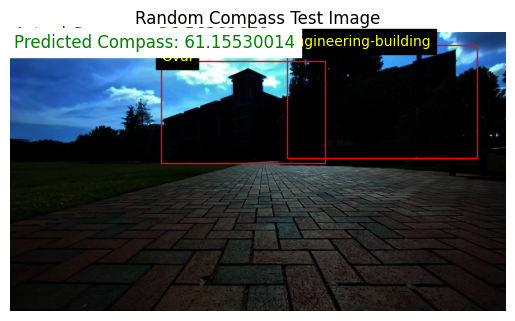

Actual Compass: 28.70441628
Predicted Compass: 78.59941101


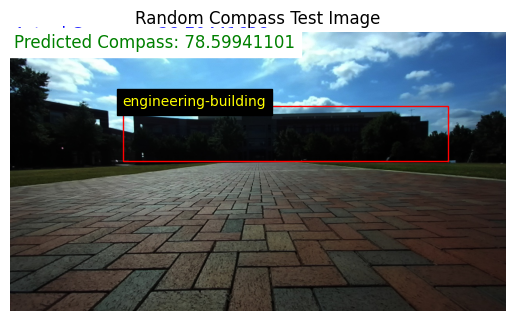

In [14]:
# Result of compass model
import random
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

# Evaluate the compass model on the test set
compass_model.eval()
compass_predictions = []
compass_targets = []
compass_image_paths = []

# Use compass_test_dataloader for evaluation
with torch.no_grad():
    for inputs, targets, paths in compass_test_dataloader:
        outputs = compass_model(inputs)
        compass_predictions.append(outputs)
        compass_targets.append(targets)
        compass_image_paths.extend(paths)

# Combine all predictions and targets for compass orientation
compass_predictions = torch.cat(compass_predictions, dim=0)
compass_targets = torch.cat(compass_targets, dim=0)

# Calculate Mean Squared Error for compass orientation
compass_mse = criterion(compass_predictions, compass_targets).item()
print(f'Mean Squared Error on Compass Test Set: {compass_mse:.8f}')

compass_rmse = math.sqrt(compass_mse)
print(f'Root Mean Squared Error (RMSE) on Compass Test Set: {compass_rmse:.8f}')

# Function to visualize random test images with compass orientation labels
def visualize_random_compass_predictions(test_dataset, compass_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_orientation = compass_predictions[i].cpu().numpy()[0]
        actual_orientation = geolocation[0].item()

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display compass orientation with clear labels
        plt.text(10, 20, f"Actual Compass: {actual_orientation:.8f}", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Compass: {predicted_orientation:.8f}", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Compass: {actual_orientation:.8f}")
        print(f"Predicted Compass: {predicted_orientation:.8f}")
        
        plt.title('Random Compass Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the compass test set
visualize_random_compass_predictions(compass_test_dataset, compass_predictions, num_images=10)


In [9]:
# Loading the lat, lon model 
lat_lon_model = LatLonModel()
lat_lon_model.load_state_dict(torch.load("0.00065MSE_LAT_LON.pt", weights_only=True))
lat_lon_model.eval()

LatLonModel(
  (fc1): Linear(in_features=72, out_features=40, bias=True)
  (bn1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=40, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Mean Squared Error on Test Set (Lat/Lon): 0.00000033
Root Mean Squared Error (RMSE) on Test Set (Lat/Lon): 0.00057181
Actual Lat/Lon: (35.77114868, -78.67392731)
Predicted Lat/Lon: (35.77072906, -78.67489624)


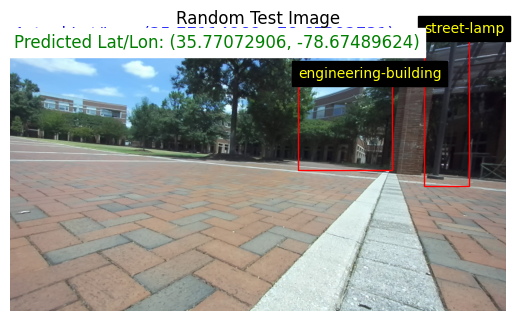

Actual Lat/Lon: (35.77111053, -78.67391968)
Predicted Lat/Lon: (35.77067184, -78.67494202)


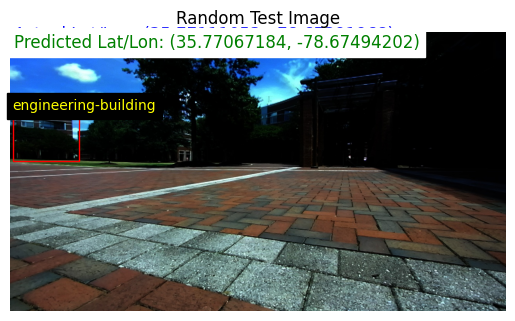

Actual Lat/Lon: (35.77138901, -78.67387390)
Predicted Lat/Lon: (35.77090073, -78.67478180)


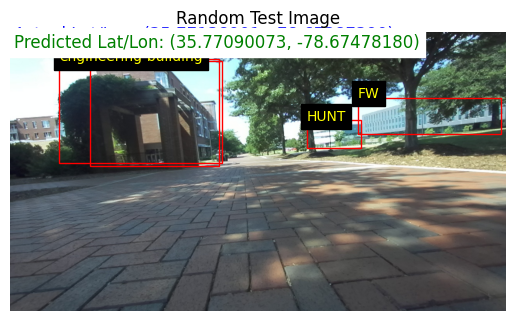

Actual Lat/Lon: (35.77043152, -78.67557526)
Predicted Lat/Lon: (35.77066803, -78.67500305)


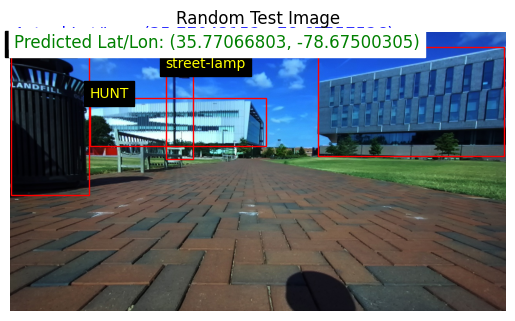

Actual Lat/Lon: (35.77133942, -78.67485046)
Predicted Lat/Lon: (35.77081299, -78.67487335)


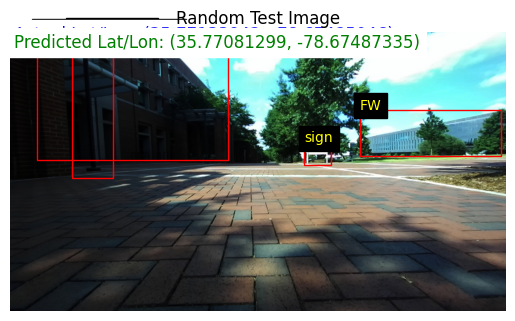

Actual Lat/Lon: (35.77055740, -78.67549896)
Predicted Lat/Lon: (35.77064896, -78.67507172)


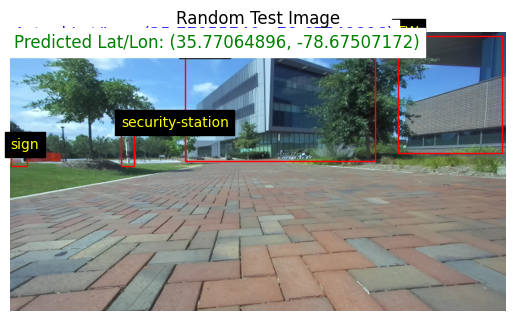

Actual Lat/Lon: (35.77043915, -78.67453003)
Predicted Lat/Lon: (35.77050400, -78.67499542)


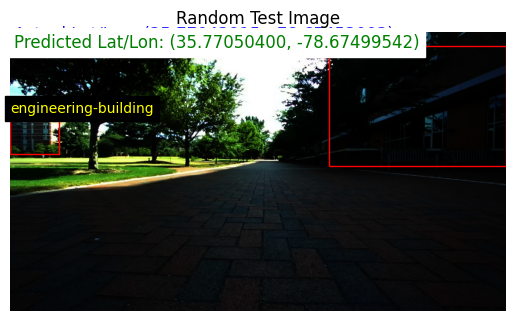

Actual Lat/Lon: (35.77106476, -78.67404175)
Predicted Lat/Lon: (35.77082443, -78.67486572)


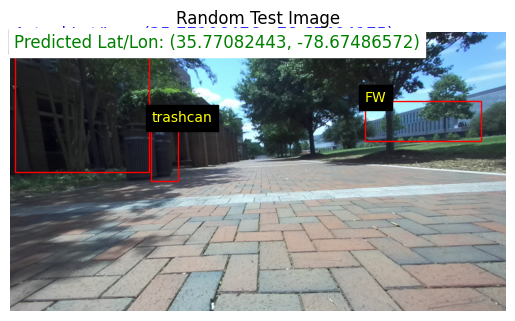

Actual Lat/Lon: (35.77107620, -78.67505646)
Predicted Lat/Lon: (35.77061081, -78.67498779)


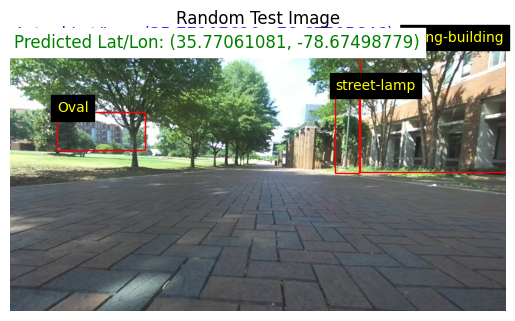

Actual Lat/Lon: (35.77075577, -78.67466736)
Predicted Lat/Lon: (35.77074814, -78.67495728)


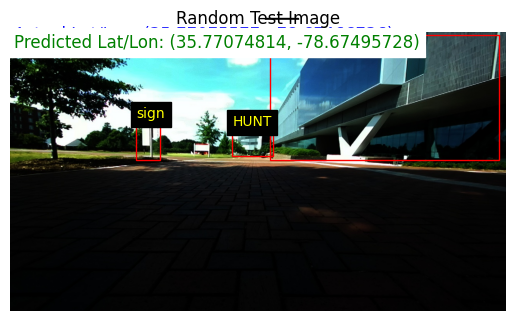

In [12]:
# Evaluate the lat_lon_model on the test set
all_predictions = []
all_targets = []
image_paths = []

criterion = nn.MSELoss()

with torch.no_grad():
    for inputs, targets, paths in lat_lon_test_dataloader:
        outputs = lat_lon_model(inputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.extend(paths)

# Combine all predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Mean Squared Error for Lat/Lon
mse = criterion(all_predictions, all_targets).item()
print(f'Mean Squared Error on Test Set (Lat/Lon): {mse:.8f}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set (Lat/Lon): {rmse:.8f}')

# Function to visualize random test images with bounding boxes and geolocation labels
def visualize_random_predictions(test_dataset, all_predictions, num_images=5):
    indices = random.sample(range(len(test_dataset)), num_images)
    
    for i in indices:
        bounding_box, geolocation, image_path = test_dataset[i]
        predicted_output = all_predictions[i].cpu().numpy()
        
        # Latitude and longitude
        predicted_lat_lon = predicted_output[:2]
        actual_lat_lon = geolocation[:2].numpy()

        # Load and plot the image
        image = Image.open(image_path)
        plt.imshow(image)
        
        # Plot all bounding boxes from the COCO annotations for this image
        num_classes = 9  # Assuming 9 classes, adjust if necessary
        max_instances_per_class = 2  # Assuming a maximum of 2 instances per class
        class_names = ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']  # Replace with actual class names

        for class_id in range(num_classes):
            for instance in range(max_instances_per_class):
                start_index = (class_id * max_instances_per_class + instance) * 4
                x, y, w, h = bounding_box[start_index:start_index+4].numpy()
                if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
                    plt.gca().add_patch(rect)
                    plt.text(x, y, f'{class_names[class_id]}', color='yellow', fontsize=10, backgroundcolor='black')
        
        # Display geolocations with clear labels (latitude and longitude)
        plt.text(10, 20, f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})", color='blue', fontsize=12, backgroundcolor='white')
        plt.text(10, 40, f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})", color='green', fontsize=12, backgroundcolor='white')
        
        print(f"Actual Lat/Lon: ({actual_lat_lon[0]:.8f}, {actual_lat_lon[1]:.8f})")
        print(f"Predicted Lat/Lon: ({predicted_lat_lon[0]:.8f}, {predicted_lat_lon[1]:.8f})")
        
        plt.title('Random Test Image')
        plt.axis('off')
        plt.show()

# Visualize random images from the test set
visualize_random_predictions(lat_lon_test_dataset, all_predictions, num_images=10)